<h2>About this Project</h2>

In this project, you will implement the CART (Classification and Regression Tree) algorithm. You will work with the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">Ionosphere Data Set from the UCI Machine Learning Repository</a>, which consists of radar data from a system designed to target free electrons in the ionosphere, and a artificial "spiral" dataset. The first dataset will be used to determine if a radar return was "good" (i.e. a signal was returned) or "bad" (i.e. the signal passed straight through the ionosphere).

**You will be using a regression tree with squared loss impurity to do classification. This is possible here because all classification problems can be framed as regression problems. You could also have used a classification tree with Gini impurity equivalently.**

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
</ol>

<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

<h2>Implementing Regression Trees</h2>

### Getting Started

Before you get started, let's import a few packages that you will need. In addition, you will load two binary classification dataset - the spiral dataset and the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a> dataset. 

In [1]:
import numpy as np
import pandas as pd
from pylab import *
from numpy.matlib import repmat
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import sys

%matplotlib inline

sys.path.append('/home/codio/workspace/.modules')
from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.6.8


The code below generates spiral data using the trigonometric functions sine and cosine, then splits the data into train and test segments.

In [2]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N) # generate a vector of "radius" values
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T # generate a curve that draws circles with increasing radius
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    # Now sample alternating values to generate the test and train sets.
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr, yTr, xTe, yTe

xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)
print(f'Number of training points in spiral dataset: {xTrSpiral.shape[0]}')
print(f'Number of testing points in spiral dataset: {xTeSpiral.shape[0]}')
print(f'Number of features in spiral dataset: {xTrSpiral.shape[1]}')

Number of training points in spiral dataset: 150
Number of testing points in spiral dataset: 150
Number of features in spiral dataset: 2


Each data point $[\mathbf{x}]_i$ in the spiral data has 2 dimensions and the label $y_i$ is either $-1$ or $+1$. We can plot `xTrSpiral` to see the points, colored by the label they are associated with.

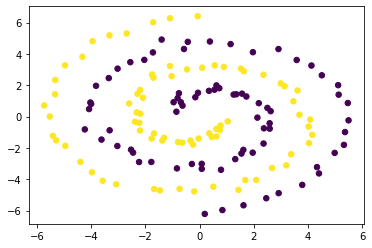

In [3]:
plt.scatter(xTrSpiral[:, 0], xTrSpiral[:, 1], s=30, c=yTrSpiral)

The following code loads the ION dataset.

In [4]:
# Load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")

# Load the training data
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()

# Load the test data
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

print(f'Number of training points in ION dataset: {xTrIon.shape[0]}')
print(f'Number of testing points in ION dataset: {xTeIon.shape[0]}')
print(f'Number of features in ION dataset: {xTrIon.shape[1]}')
print('Training set: (n x d matrix)')
TrIon_for_display = np.concatenate([yTrIon[:, None], xTrIon], axis=1)
TrIon_for_display = TrIon_for_display[TrIon_for_display[:, 0].argsort()]

display(pd.DataFrame(data=TrIon_for_display,
                     columns=['$y$'] + [f'$[\mathbf{{x}}]_{ {i+1} }$' for i in range(xTrIon.shape[1])]).round(2))

Number of training points in ION dataset: 281
Number of testing points in ION dataset: 70
Number of features in ION dataset: 34
Training set: (n x d matrix)


,$y$,$[\mathbf{x}]_{1}$,$[\mathbf{x}]_{2}$,$[\mathbf{x}]_{3}$,$[\mathbf{x}]_{4}$,$[\mathbf{x}]_{5}$,$[\mathbf{x}]_{6}$,$[\mathbf{x}]_{7}$,$[\mathbf{x}]_{8}$,$[\mathbf{x}]_{9}$,...,$[\mathbf{x}]_{25}$,$[\mathbf{x}]_{26}$,$[\mathbf{x}]_{27}$,$[\mathbf{x}]_{28}$,$[\mathbf{x}]_{29}$,$[\mathbf{x}]_{30}$,$[\mathbf{x}]_{31}$,$[\mathbf{x}]_{32}$,$[\mathbf{x}]_{33}$,$[\mathbf{x}]_{34}$
0,-1.0,0.55,1.66,-0.56,1.01,1.83,-0.46,1.91,-1.48,-1.15,...,-0.51,-0.46,0.58,0.30,0.19,-0.30,-0.48,-0.45,-0.09,-0.0
1,-1.0,0.23,-0.04,1.61,-0.09,-0.23,-1.59,1.35,0.34,-0.03,...,0.36,-0.24,0.06,-0.21,-0.21,-0.04,0.00,0.22,0.08,-0.0
2,-1.0,2.18,-1.05,0.27,2.20,2.15,-2.48,-0.13,1.76,0.14,...,0.02,0.27,0.08,0.15,-0.22,0.09,-0.34,-0.45,-0.15,-0.0
3,-1.0,-2.10,1.56,0.55,-1.53,-0.92,-0.31,2.06,-0.30,-0.15,...,-0.53,0.30,-0.74,0.03,-0.14,0.23,0.00,-0.18,-0.02,0.0
4,-1.0,1.55,0.18,0.74,0.78,0.18,0.38,-0.10,-0.21,-0.63,...,0.01,0.19,-0.18,-0.18,0.02,-0.04,-0.22,0.19,0.05,-0.0
5,-1.0,1.39,-0.10,1.67,-0.34,-0.23,-0.01,0.56,-0.51,-0.76,...,-0.26,0.04,-0.19,0.01,0.19,0.42,0.05,0.08,-0.42,-0.0
6,-1.0,-1.63,-0.51,-2.12,0.92,1.84,0.13,-0.75,1.20,0.81,...,-0.46,0.43,0.07,0.08,0.59,0.33,-0.53,0.19,-0.30,-0.0
7,-1.0,0.99,0.60,0.38,0.79,-0.44,-0.42,0.07,0.27,-0.33,...,-0.39,0.05,-0.02,0.09,-0.20,-0.29,0.35,0.15,-0.15,0.0
8,-1.0,0.92,-0.64,1.08,0.34,0.30,0.24,-0.05,-0.51,-0.70,...,0.90,0.14,-0.06,0.14,-0.06,0.64,0.19,-0.05,-0.41,0.0
9,-1.0,0.53,-1.95,1.07,-0.94,1.34,-0.21,-0.23,-0.30,-0.66,...,-0.04,0.01,0.54,-0.68,0.34,-0.57,-0.32,-0.06,-0.14,-0.0


### Part One: Implement `sqimpurity` [Graded]

First, implement the function **`sqimpurity`**, which takes as input a vector $y$ of $n$ labels and outputs the corresponding squared loss impurity:
$$
\sum_{i = 1}^{n} \left( y_i - \overline{y} \right)^2 \textrm{, where } \overline{y} = \frac{\sum_{i=1}^{n} y_i}{n}.
$$

Again, the squared loss impurity works fine even though our final objective is classification. This is because the labels are binary and classification problems can be framed as regression problems.

In [5]:
def sqimpurity(yTr):
    """
    Computes the squared loss impurity (variance) of the labels.
    
    Input:
        yTr: n-dimensional vector of labels
    
    Output:
        squared loss impurity: weighted variance/squared loss impurity of the labels
    """
    
    N, = yTr.shape
    assert N > 0 # must have at least one sample
    impurity = 0
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    yavg = 1/N * np.sum(yTr)
    impurity = np.sum((yTr - yavg)**2)
    
    return impurity

In [6]:
def sqimpurity_test1():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr) # compute impurity
    return np.isscalar(impurity)  # impurity should be scalar

def sqimpurity_test2():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr) # compute impurity
    return impurity >= 0 # impurity should be nonnegative

def sqimpurity_test3():
    yTr = np.ones(100) # generate an all one vector as labels
    impurity = sqimpurity(yTr) # compute impurity
    return np.isclose(impurity, 0) # impurity should be zero since the labels are homogeneous

def sqimpurity_test4():
    yTr = np.arange(-5, 6) # generate a vector with mean zero
    impurity = sqimpurity(yTr) # compute impurity
    sum_of_squares = np.sum(yTr ** 2) 
    return np.isclose(impurity, sum_of_squares) # with mean zero, then the impurity should be the sum of squares

def sqimpurity_test5():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr)
    impurity_grader = sqimpurity_grader(yTr)
    return np.isclose(impurity, impurity_grader)

runtest(sqimpurity_test1, 'sqimpurity_test1')
runtest(sqimpurity_test2, 'sqimpurity_test2')
runtest(sqimpurity_test3, 'sqimpurity_test3')
runtest(sqimpurity_test4, 'sqimpurity_test4')
runtest(sqimpurity_test5, 'sqimpurity_test5')

Running Test: sqimpurity_test1 ... ✔ Passed!
Running Test: sqimpurity_test2 ... ✔ Passed!
Running Test: sqimpurity_test3 ... ✔ Passed!
Running Test: sqimpurity_test4 ... ✔ Passed!
Running Test: sqimpurity_test5 ... ✔ Passed!


In [7]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test1

In [8]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test2

In [9]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test3

In [10]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test4

In [11]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test5

Let's plot the shape of the impurity function. We vary the mixture of labels in a set of $n$ labels and calculate the impurity of the labels. When the labels are mostly the same, the impurity should be low. When the labels are evenly split between $+1$ and $-1$, the impurity should be the highest.

,fraction_pos,impurity
0,1.0,0.0
1,0.9,3.6
2,0.8,6.4
3,0.7,8.4
4,0.6,9.6
5,0.5,10.0
6,0.4,9.6
7,0.3,8.4
8,0.2,6.4
9,0.1,3.6


Text(0, 0.5, 'Squared loss impurity of labels')

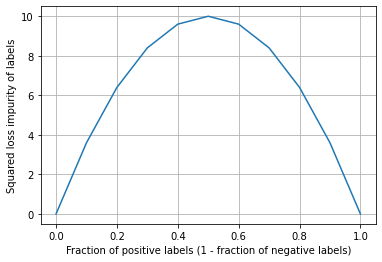

In [12]:
size = 10
y = np.ones(size)
fraction_pos, impurities = [], []
for i in range(size):
    fraction_pos.append(sum([y == 1]) / size)
    impurities.append(sqimpurity(y))
    y[i] = -1
fraction_pos.append(sum([y == 1]) / size)
impurities.append(sqimpurity(y))

display(pd.DataFrame(data={'fraction_pos': fraction_pos, 'impurity': impurities}))
plt.plot(fraction_pos, impurities)
plt.grid()
plt.xlabel('Fraction of positive labels (1 - fraction of negative labels)')
plt.ylabel('Squared loss impurity of labels')

### Part Two: Implement `sqsplit` [Graded]

Now implement **`sqsplit`**, which takes as input a data set of size $n \times d$ with labels and computes the best feature and the threshold/cut of the optimal split based on the squared loss impurity. The function outputs a feature dimension `0 <= feature < d`, a cut threshold `cut`, and the impurity loss `bestloss` of this best split.

Recall in the CART algorithm that, to find the split with the minimum impurity, you iterate over all features and cut values along each feature. We enforce that the cut value be the average of the two consecutive data points' feature values.

You should calculate the impurity of a node of data $S$ with two branches $S_L$ and $S_R$ as:
$$
\begin{align*}
I(S) &= \frac{\left| S_L \right|}{|S|} I \left( S_L \right) + \frac{\left| S_R \right|}{|S|} I \left( S_R \right)\\
&= \frac{1}{|S|}\sum_{(\mathbf{x}, y) \in S_L} \left( y-\overline{y}_{S_L} \right)^2 + \frac{1}{|S|} \sum_{(\mathbf{x}, y) \in S_R} \left( y - \overline{y}_{S_R} \right)^2\\
&\propto \sum_{(\mathbf{x}, y) \in S_L} \left( y-\overline{y}_{S_L} \right)^2 + \sum_{(\mathbf{x}, y) \in S_R} \left( y - \overline{y}_{S_R} \right)^2
\end{align*}
$$

**Implementation Notes:**
- For calculating the impurity of a node, you should just return the sum of left and right impurities instead of the average.
- Returned `feature` must be 0-indexed as is consistent with programming in Python.
- If along a feature $f$, two data points $\mathbf{x}_i$ and $\mathbf{x}_j$ have the same value, avoid splitting between them; move to the next pair of data points.

For example, with the following `xTr` of size $4 \times 3$ and `yTr` for 4 points:
$$
\begin{bmatrix}
1 & 0 & 2\\
2 & 0 & 1\\
0 & 0 & 1\\
2 & 1 & 2
\end{bmatrix},
\begin{bmatrix}
1\\1\\1\\-1
\end{bmatrix}
$$
among possible features `[0, 1, 2]`, the best split would be at `feature = 1` and `cut = (0 + 1) / 2 = 0.5`.

<hr>

If you're stuck, we recommend that you start with the naïve algorithm for finding the best split, which involves a double loop over all features `0 <= f < d` and all cut values `xTr[0, f] < (xTr[i, f] + xTr[i+1, f]) / 2 < xTr[n-1, f]` (with `xTr` sorted along feature `f`). This algorithm thus calculates impurities for `d(n-1)` splits. Here's the pseudocode:

<center><img src="cart-id3_best_split_pseudocode.png" width="75%" /></center>

In [13]:
def sqsplit(xTr, yTr):
    """
    Finds the best feature, cut value, and impurity for a split of (xTr, yTr) based on squared loss impurity.
    
    Input:
        xTr: n x d matrix of data points
        yTr: n-dimensional vector of labels
    
    Output:
        feature:  index of the best cut's feature (keep in mind this is 0-indexed)
        cut:      cut-value of the best cut
        bestloss: squared loss impurity of the best cut
    """
    n, d = xTr.shape
    assert d > 0 # must have at least one dimension
    assert n > 1 # must have at least two samples
    
    bestloss = np.inf
    feature = np.inf
    cut = np.inf

    # YOUR CODE HERE
    #raise NotImplementedError()
    for c in range(d): 
        sortIdx = xTr[:,c].argsort()
        #sortIdx = xTr[c,:]
        sortX = xTr[sortIdx, c]
        sortY = yTr[sortIdx]
        
        #second nested loop
        #0 -> n-1
        for i in range(n-1):
            #loops over sorted data points for cut values
            
            if sortX[i + 1] == sortX[i]:
                continue
            # moved Sl and Sr out of if statement
            # make sure Sl and Sr are defined
            Sl = sortY[:i+1]
            Sr = sortY[i+1:]

            loss = sqimpurity(Sl) + sqimpurity(Sr)

            # choose smaller loss
            if loss < bestloss:
                bestloss = loss
                cut = (sortX[i] + sortX[i + 1]) / 2
                feature = c
    
    
    
    
    return feature, cut, bestloss   

In [14]:
# The tests below check that your sqsplit function returns the correct values for several different input datasets

t0 = time.time()
fid, cut, loss = sqsplit(xTrIon,yTrIon)
t1 = time.time()

print('Elapsed time: {:0.2f} seconds'.format(t1-t0))
print("The best split is on feature 2 on value 0.304")
print("Your tree split on feature %i on value: %2.3f \n" % (fid,cut))

def sqsplit_test1():
    a = np.isclose(sqsplit(xor4, yor4)[2] / len(yor4), .25)
    b = np.isclose(sqsplit(xor3, yor3)[2] / len(yor3), .25)
    c = np.isclose(sqsplit(xor2, yor2)[2] / len(yor2), .25)
    return a and b and c

def sqsplit_test2():
    x = np.array(range(1000)).reshape(-1,1)
    y = np.hstack([np.ones(500),-1*np.ones(500)]).T
    _, cut, _ = sqsplit(x, y)
    return cut <= 500 or cut >= 499

def sqsplit_test3():
    fid, cut, loss = sqsplit(xor5,yor5)
    # cut should be 0.5 but 0 is also accepted
    return fid == 0 and (cut >= 0 or cut <= 1) and np.isclose(loss / len(yor5), 2/3)

runtest(sqsplit_test1,'sqsplit_test1')
runtest(sqsplit_test2,'sqsplit_test2')
runtest(sqsplit_test3,'sqsplit_test3')

Elapsed time: 0.53 seconds
The best split is on feature 2 on value 0.304
Your tree split on feature 2 on value: 0.304 

Running Test: sqsplit_test1 ... ✔ Passed!
Running Test: sqsplit_test2 ... ✔ Passed!
Running Test: sqsplit_test3 ... ✔ Passed!


In [15]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy

In [16]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy

In [17]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy

### Part Three: Implement `cart` [Graded]

In this section, you will implement the function **`cart`**, which returns a regression tree based on the minimum squared loss splitting rule. You should use the function `sqsplit` to make your splits.

**Implementation Notes:**
We've provided a tree structure in the form of `TreeNode` for you that can be used for both leaves and nodes. To represent the leaves, you would set all fields except `prediction` to `None`.

Non-leaf nodes will have non-`None` fields for all except `prediction`:
1. `left`: node describing left subtree
2. `right`: node describing right subtree
3. `feature`: index of feature to cut (0-indexed as returned by `sqsplit`)
4. `cut`: cutoff value $t$ ($\leq t$: left and $> t$: right)
5. `prediction`: `None`

In [18]:
class TreeNode(object):
    """
    Tree class.
    
    (You don't _need_ to add any methods or fields here but feel
    free to if you like. The tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """
    
    def __init__(self, left, right, feature, cut, prediction):
        # Check that all or no arguments are None
        node_or_leaf_args = [left, right, feature, cut]
        assert all([arg == None for arg in node_or_leaf_args]) or all([arg != None for arg in node_or_leaf_args])
        
        # Check that all None <==> leaf <==> prediction not None
        # Check that all non-None <==> non-leaf <==> prediction is None
        if all([arg == None for arg in node_or_leaf_args]):
            assert prediction is not None
        if all([arg != None for arg in node_or_leaf_args]):
            assert prediction is None
        
        self.left = left 
        self.right = right 
        self.feature = feature 
        self.cut = cut
        self.prediction = prediction 

The following cell contains some examples of trees.

In [19]:
# The following is a tree that predicts everything as zero ==> prediction 0
# In this case, it has no left or right children (it is a leaf node) ==> left = None, right = None, feature = None, cut = None
root = TreeNode(None, None, None, None, 0)


# The following that a tree with depth 2 or a tree with one split 

# The tree will return a prediction of 1 if an example falls under the left subtree
# Otherwise it will return a prediction of 2
# To start, first create two leaf node
left_leaf = TreeNode(None, None, None, None, 1)
right_leaf = TreeNode(None, None, None, None, 2)

# Now create the parent or the root
# Suppose we split at feature 0 and cut of 1 and the prediction is None
root2 = TreeNode(left_leaf, right_leaf, 0, 1, None)

# Now root2 is the tree we desired

Now implement the function `cart` using **recursion** (you call `cart` on the left and right subtrees inside the `cart` function). Recall the pseudocode for the CART algorithm.

**NOTE:** In this implementation, you will be using **`np.mean`** for `prediction` argument. To check that floating point values in `xTr` are the same or not, you can use `np.isclose(xTr, xTr[0])`, which returns a list of `True` and `False` based on how different the rows of `xTr` are from the vector `xTr[0]`.

<center><img src="cart-id3_pseudocode.png" width="75%" /></center>

In [20]:
def cart(xTr, yTr):
    """
    Builds a CART tree.
    
    Input:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector

    Output:
        tree: root of decision tree
    """
    n, d = xTr.shape
    node = None
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    prediction = np.mean(yTr)
    
    
    #test = yTr[yTr[0] == yTr] 
    #test will be length n if yTr[0] exactly matches every other value in yTr (all labels are equal)
    #test.shape[0] == n
    
    #all labels are equal
    if np.all(yTr == yTr[0]):
        #return leaf 
        tree = TreeNode(None, None, None, None, prediction)
    else:
        #generating left and right trees
        feature, cut, loss = sqsplit(xTr, yTr)
        if feature == np.inf or cut == np.inf or loss == np.inf:
            tree = TreeNode(None, None, None, None, prediction)
            return tree
        
        
        #cuts xTr and yTr according to whether or not they are past partition
        leftX  = xTr[xTr[:, feature] <= cut, :]
        rightX = xTr[xTr[:, feature] > cut, :]
        leftY = yTr[xTr[:, feature] <= cut]
        rightY = yTr[xTr[:, feature] > cut]
        
        #recursive call on left and right splits 
        left = cart(leftX, leftY)
        right = cart(rightX, rightY)
        
        #generates tree
        # tree = TreeNode(left, right, feature, cut, prediction)
        # predictions are at LEAVES only
        tree = TreeNode(left, right, feature, cut, None)
        left.parent = tree
        right.parent = tree
        
        
        
        
        
    return tree
    

In [21]:
# The tests below check that your implementation of cart  returns the correct predicted values for a sample dataset

#test case 1
def cart_test1():
    t=cart(xor4,yor4)
    return DFSxor(t)

#test case 2
def cart_test2():
    y = np.random.rand(16);
    t = cart(xor4,y);
    yTe = DFSpreds(t)[:];
    # Check that every label appears exactly once in the tree
    y.sort()
    yTe.sort()
    return np.all(np.isclose(y, yTe))

#test case 3
def cart_test3():
    xRep = np.concatenate([xor2, xor2])
    yRep = np.concatenate([yor2, 1-yor2])
    t = cart(xRep, yRep)
    return DFSxorUnsplittable(t)

#test case 4
def cart_test4():
    X = np.ones((5, 2)) # Create a dataset with identical examples
    y = np.ones(5)
    
    # On this dataset, your cart algorithm should return a single leaf
    # node with prediction equal to 1
    t = cart(X, y)
    
    # t has no children
    children_check = (t.left is None) and (t.right is None) 
    
    # Make sure t does not cut any feature and at any value
    feature_check = (t.feature is None) and (t.cut is None)
    
    # Check t's prediction
    prediction_check = np.isclose(t.prediction, 1)
    return children_check and feature_check and prediction_check

#test case 5
def cart_test5():
    X = np.arange(4).reshape(-1, 1)
    y = np.array([0, 0, 1, 1])

    t = cart(X, y) # your cart algorithm should generate one split
    
    # check whether you set t.feature and t.cut to something
    return t.feature is not None and t.cut is not None



runtest(cart_test1,'cart_test1')
runtest(cart_test2,'cart_test2')
runtest(cart_test3,'cart_test3')
runtest(cart_test4,'cart_test4')
runtest(cart_test5,'cart_test5')

Running Test: cart_test1 ... ✔ Passed!
Running Test: cart_test2 ... ✔ Passed!
Running Test: cart_test3 ... ✔ Passed!
Running Test: cart_test4 ... ✔ Passed!
Running Test: cart_test5 ... ✔ Passed!


In [22]:
# Autograder test cell - worth 1 Point
# runs cart_test1

In [23]:
# Autograder test cell - worth 1 Point
# runs cart_test2

In [24]:
# Autograder test cell - worth 1 Point
# runs cart_test3

In [25]:
# Autograder test cell - worth 1 Point
# runs cart_test4

In [26]:
# Autograder test cell - worth 1 Point
# runs cart_test5

### Part Four: Implement `evaltree` [Graded]

Implement the function **`evaltree`**, which evaluates a decision tree on a given test data set. You essentially need to traverse the tree until you end up in a leaf, where you return the `prediction` value of the leaf. Like the `cart` function, you can call `evaltree` on the left subtree and right subtree on testing points that fall in the corresponding subtrees.

Here's some inspiration:
1. If the `tree` is a leaf, i.e. the left and right subtrees are `None`, return `tree.prediction` for all `m` testing points.
2. If the `tree` is non-leaf, using `tree.feature` and `tree.cut` find testing points with the feature value less than/equal to the threshold and greater than. Now, you can call `evaltree` on `tree.left` and the left set of testing points to obtain the left set's predictions. Then obtain the predictions for the right set, and return all predictions.

In [41]:
def evaltree(tree, xTe):
    """
    Evaluates testing points in xTe using decision tree root.
    
    Input:
        tree: TreeNode decision tree
        xTe:  m x d matrix of data points
    
    Output:
        pred: m-dimensional vector of predictions
    """
    m, d = xTe.shape
    preds = np.zeros(m)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    for i in range(m):
        r = tree
        #loop until end of tree
        while r.left != None and r.right != None:
            if xTe[i, r.feature] <= r.cut:
                # falls on left side of partition
                r = r.left
            else:
                #falls on right side
                r = r.right
                
        
        preds[i] = r.prediction
            
            
    return preds
    
        

In [42]:
# The following tests check that your implementation of evaltree returns the correct predictions for two sample trees

t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

#test case 1
def evaltree_test1():
    t = cart(xor4,yor4)
    xor4te = xor4 + (np.sign(xor4 - .5) * .1)
    inds = np.arange(16)
    np.random.shuffle(inds)
    # Check that shuffling and expanding the data doesn't affect the predictions
    return np.all(np.isclose(evaltree(t, xor4te[inds,:]), yor4[inds]))

#test case 2
def evaltree_test2():
    a = TreeNode(None, None, None, None, 1)
    b = TreeNode(None, None, None, None, -1)
    c = TreeNode(None, None, None, None, 0)
    d = TreeNode(None, None, None, None, -1)
    e = TreeNode(None, None, None, None, -1)
    x = TreeNode(a, b, 0, 10, None)
    y = TreeNode(x, c, 0, 20, None)
    z = TreeNode(d, e, 0, 40, None)
    t = TreeNode(y, z, 0, 30, None)
    # Check that the custom tree evaluates correctly
    return np.all(np.isclose(
            evaltree(t, np.array([[45, 35, 25, 15, 5]]).T),
            np.array([-1, -1, 0, -1, 1])))

runtest(evaltree_test1,'evaltree_test1')
runtest(evaltree_test2,'evaltree_test2')

Elapsed time: 2.23 seconds
Training RMSE : 0.00
Testing  RMSE : 0.69 

Running Test: evaltree_test1 ... ✔ Passed!
Running Test: evaltree_test2 ... ✔ Passed!


In [43]:
# Autograder test cell - worth 1 Point
# runs evaltree_test1

In [44]:
# Autograder test cell - worth 1 Point
# runs evaltree_test2

<h3> Training and Testing a Classification Tree on the ION Dataset</h3>

<p> The following code create a classification tree on the ION dataset and then apply the learned tree to an unknown dataset. If you implement everything correctly, you should get a training RSME that is close to zero.</p>

In [45]:
t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

Elapsed time: 2.15 seconds
Training RMSE : 0.00
Testing  RMSE : 0.69 



<h3> Visualize Your Tree</h3>

<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

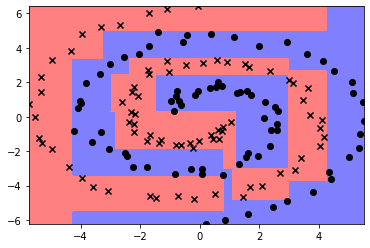

Training error: 0.0000
Testing error:  0.0400


In [46]:
def visclassifier(fun,xTr,yTr,w=None,b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    
    if w is not None:
        w = np.array(w).flatten()
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    # shows figure and blocks
    plt.show()

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X), xTrSpiral, yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

<IPython.core.display.Javascript object>


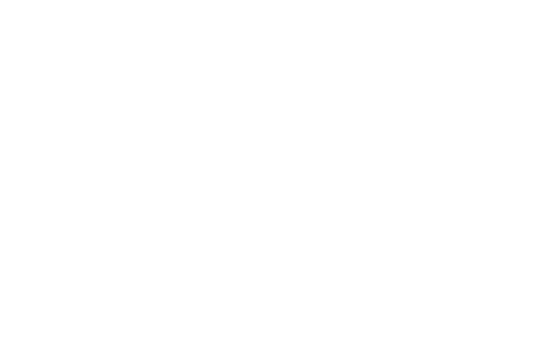

Text(0.5, 1.0, 'Click to add positive points and use shift-click to add negative points.')

<IPython.core.display.Javascript object>


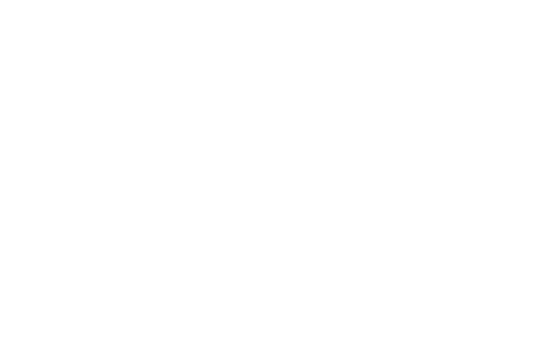

In [47]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()

%matplotlib notebook
xTraining= np.array([[5,6]])
labels = [1]
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Click to add positive points and use shift-click to add negative points.')

### Scikit-learn

Scikit-learn also provides an implementation of [Regression Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) (and [Decision Tree Classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)). The usage is pretty straight-forward: define the regression tree with the impurity function (and other settings), fit to the training set, and evaluate on any dataset.

In [48]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

t0 = time.time()
tree = DecisionTreeRegressor(
    criterion='mse', # Impurity function = Mean Squared Error (squared loss)
    splitter='best', # Take the best split
    max_depth=None, # Expand the tree to the maximum depth possible
)
tree.fit(xTrSpiral, yTrSpiral)
t1 = time.time()

tr_err   = np.mean((tree.predict(xTrSpiral) - yTrSpiral)**2)
te_err   = np.mean((tree.predict(xTeSpiral) - yTeSpiral)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

Elapsed time: 0.00 seconds
Training RMSE : 0.00
Testing  RMSE : 0.16 



Scikit-learn also provides a tree plotting function, which is again quite simple to use. This is extremely useful while debugging a decision tree.

<IPython.core.display.Javascript object>


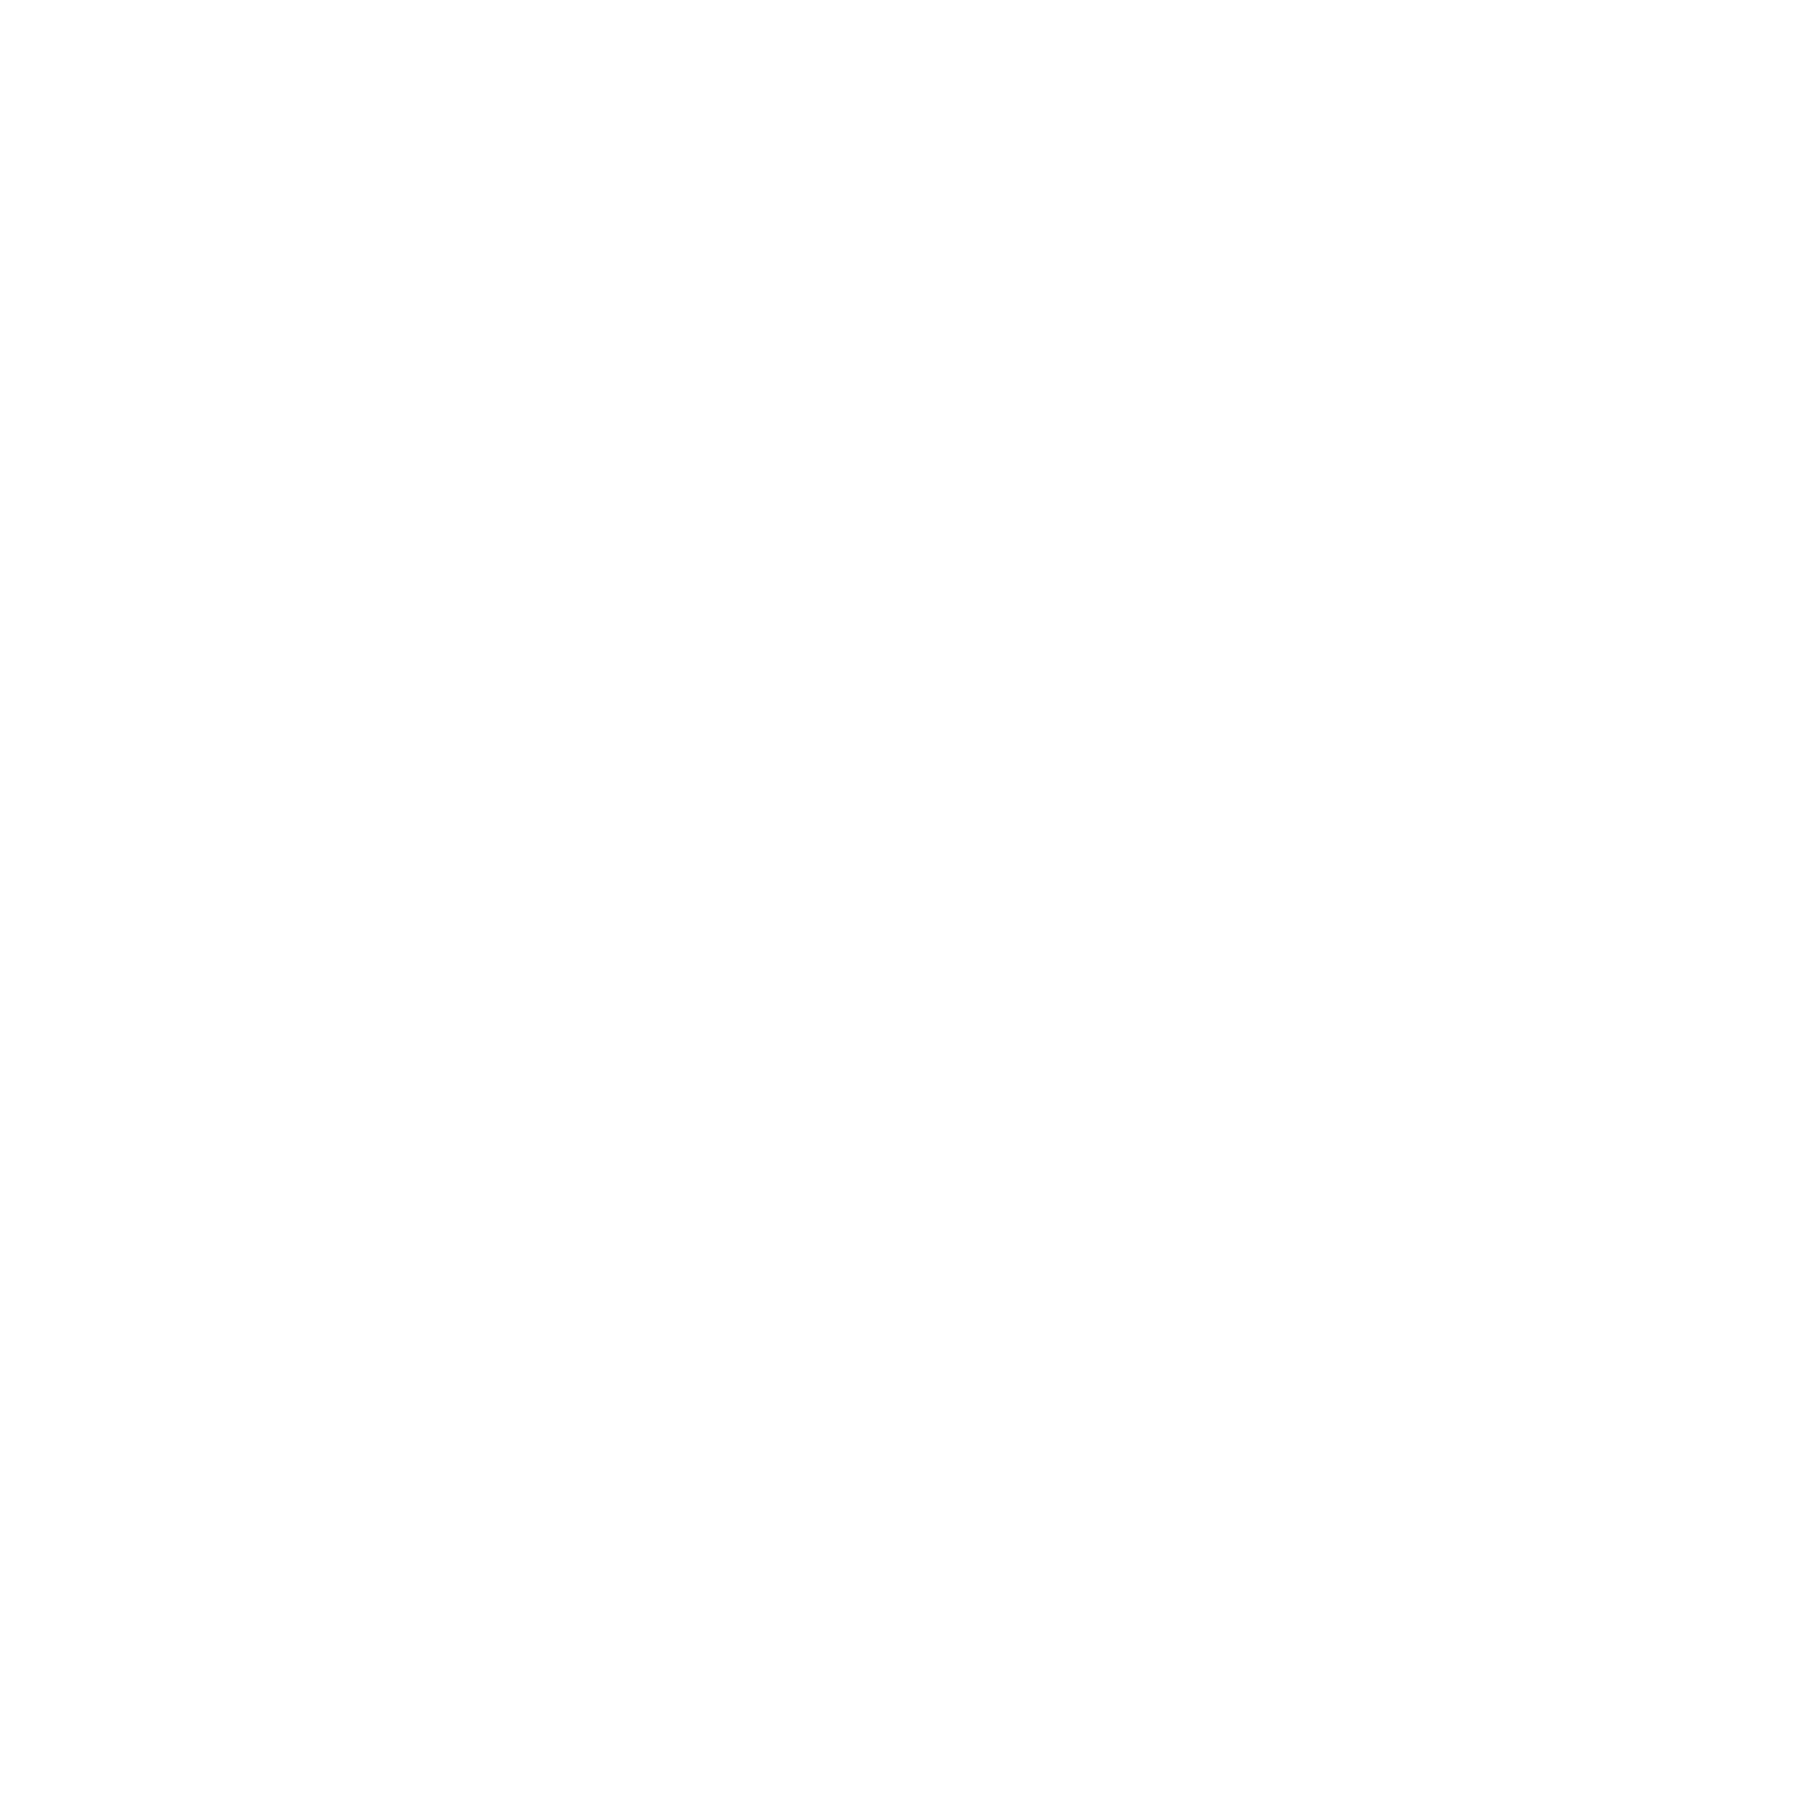

<IPython.core.display.Javascript object>


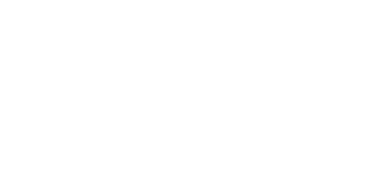

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
_ = plot_tree(tree, ax=ax, precision=2, feature_names=[f'$[\mathbf{{x}}]_{i+1}$' for i in range(2)], filled=True)